<a href="https://colab.research.google.com/github/nprime496/building-floor-recognition/blob/main/code/audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sortie de u-net avec plusieurs channels

# BUILDING FLOOR RECOGNITION


Remember:

* Train with more data
* Data Augmentation
* adding noise to the input and ouput data
* feature selection
* cross-validation
* simplify data
* regularization
* emsembling
* early stopping
* adding dropout layers


## setup

In [168]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [169]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.autograd import Variable
from torch import nn

print(torch.__version__)
print(torchaudio.__version__)

1.11.0+cu113
0.11.0+cu113


In [170]:
import random 
import os
from copy import deepcopy

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [172]:
from IPython.display import Audio, display
from typing import Dict,Any

In [173]:
import librosa


In [174]:
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [175]:
def seed_all(SEED_VAL=1):
        random.seed(SEED_VAL)
        np.random.seed(SEED_VAL)
        torchaudio.utils.sox_utils.set_seed(SEED_VAL)
        torch.manual_seed(SEED_VAL)
        torch.cuda.manual_seed_all(SEED_VAL)
        os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [176]:
seed_all(496)

In [177]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [178]:
import wandb

wandb.login()

True

In [179]:
import wandb
assert True,"setup wandb"
#wandb.init(project="my-awesome-project")

## utils

In [180]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


In [181]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


In [182]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


In [183]:

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


In [184]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


## Data 

In [185]:
!zip -r Data_cleaned.zip Data/

updating: Data/ (stored 0%)
updating: Data/building_floor_recognition.csv (deflated 73%)
updating: Data/R+5/ (stored 0%)
updating: Data/R+5/FV13_B_1/ (stored 0%)
updating: Data/R+5/FV13_B_1/Esquissons_FV13B_1.wav (deflated 20%)
updating: Data/R+5/FV11/ (stored 0%)
updating: Data/R+5/FV11/Esquissons_FV11 wave.wav (deflated 24%)
updating: Data/R+5/VM04/ (stored 0%)
updating: Data/R+5/VM04/Esquissons_VM04.wav (deflated 17%)
updating: Data/R+5/FV13_B_2/ (stored 0%)
updating: Data/R+5/FV13_B_2/Esquissons_FV13B_2.wav (deflated 21%)
updating: Data/R+5/FV12/ (stored 0%)
updating: Data/R+5/FV12/Esquissons_FV12_2 wave.wav (deflated 23%)
updating: Data/R+5/HS20/ (stored 0%)
updating: Data/R+5/HS20/Esquissons_HS20S01 wave.wav (deflated 21%)
updating: Data/R+5/CB02/ (stored 0%)
updating: Data/R+5/CB02/Esquissons_CB02S01 wave.wav (deflated 20%)
updating: Data/R+5/FV14/ (stored 0%)
updating: Data/R+5/FV14/Esquissons_FV14 wave.wav (deflated 19%)
updating: Data/R+5/FV13_A/ (stored 0%)
updating: Data/R+

In [186]:
!rm -r Data/R+1/
!rm -r Data/R+5/

In [187]:
# Unzip dataset
!wget https://aptikal.imag.fr/~amini/Data.zip 
!unzip -o Data.zip
!rm Data.zip
!unzip -o Data/R+1.zip
!rm Data/R+1.zip
!unzip -o Data/R+5.zip 
!rm -Data/R+5.zip
!rm -r Data

--2022-07-08 16:08:57--  https://aptikal.imag.fr/~amini/Data.zip
Resolving aptikal.imag.fr (aptikal.imag.fr)... 129.88.12.12, 2001:660:5301:61::12:12
Connecting to aptikal.imag.fr (aptikal.imag.fr)|129.88.12.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147384293 (141M) [application/zip]
Saving to: ‘Data.zip’

Data.zip            100%[===================>] 140.56M  85.1MB/s    in 1.7s    

2022-07-08 16:08:59 (85.1 MB/s) - ‘Data.zip’ saved [147384293/147384293]

Archive:  Data.zip
  inflating: __MACOSX/._Data         
  inflating: Data/R+1.zip            
  inflating: __MACOSX/Data/._R+1.zip  
  inflating: Data/.DS_Store          
  inflating: __MACOSX/Data/._.DS_Store  
  inflating: Data/R+5.zip            
  inflating: __MACOSX/Data/._R+5.zip  
Archive:  Data/R+1.zip
   creating: R+1/
  inflating: __MACOSX/._R+1          
   creating: R+1/CB09/
  inflating: __MACOSX/R+1/._CB09     
   creating: R+1/CB01/
  inflating: __MACOSX/R+1/._CB01     
   creating

In [188]:
!pwd

/content


In [189]:
from glob import glob 
import re

# This piece of code divide folders having multiple wav samples as another batiment samples

os.chdir("/content/")
for floor in [1,5]:
  cur_dir=f"R+{floor}"
  for (root,dirs,files) in os.walk(cur_dir):
    for dir in dirs:
      cur_bat = os.path.join(root,dir)
      os.chdir(cur_bat)
      if len(glob("*.wav"))==2:
        os.chdir("/content/")
        try:
          os.mkdir(cur_bat+"_2")
        except:
          pass
        all_files = glob(os.path.join(cur_bat,"*"+dir.split("_")[0]+"*_2*"))
        _ = [os.rename(os.path.join(f) ,os.path.join(cur_bat+"_2",f.split("/")[-1])) for f in all_files]
        os.rename(cur_bat,cur_bat+"_1")
      os.chdir("/content/")
    break

In [190]:
os.chdir("/content/")
for floor in [1,5]:
  cur_dir=f"R+{floor}"
  for (root,dirs,files) in os.walk(cur_dir):
    [os.remove(os.path.join(root,f)) for f in files if not f.endswith(".wav")]
    

In [191]:
!mkdir Data

In [192]:
!mv R+1 Data/R+1
!mv R+5 Data/R+5

In [193]:
d={"samples":[],"floor":[]}
os.chdir("/content/Data")
for floor in [1,5]:
  cur_dir=f"R+{floor}"
  for (root,dirs,files) in os.walk(cur_dir):
    for f in files:
      if f.endswith(".wav"):
        d["samples"].append(os.path.join(root,f))
        d["floor"].append(floor)

In [194]:
dataset = pd.DataFrame.from_dict(d)
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.floor.replace({1:0,5:1},inplace=True)
dataset.head()

,samples,floor
0,R+1/VM02_2/Esquissons_VM02_2.wav,0
1,R+5/FV13_B_2/Esquissons_FV13B_2.wav,1
2,R+1/VM02_1/Esquissons_VM02_1.wav,0
3,R+5/CB06/Esquissons_CB6S01 wave.wav,1
4,R+1/CB04_2/Esquissons_CB04_2.wav,0


In [195]:
dataset.shape

(26, 2)

In [196]:
dataset.to_csv("building_floor_recognition.csv",index=False)

In [197]:
from torch.utils.data import Dataset

In [198]:
os.chdir("/content/Data/")

In [199]:
# sample wav for testing purposes
SAMPLE_WAV_PATH=dataset["samples"].sample(1).values[0]

In [200]:
metadata = torchaudio.info(SAMPLE_WAV_PATH,format="wav")
print(metadata)

AudioMetaData(sample_rate=48000, num_frames=1205702, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [201]:
waveform,sample_rate = torchaudio.load(SAMPLE_WAV_PATH,format="wav")
print_stats(waveform,sample_rate)

Sample Rate: 48000
Shape: (1, 1205702)
Dtype: torch.float32
 - Max:      0.235
 - Min:     -0.242
 - Mean:     0.000
 - Std Dev:  0.043

tensor([[-0.0281, -0.0229, -0.0163,  ...,  0.0081,  0.0045,  0.0024]])



In [202]:
play_audio(waveform,sample_rate)

## Preprocessing

### Raw

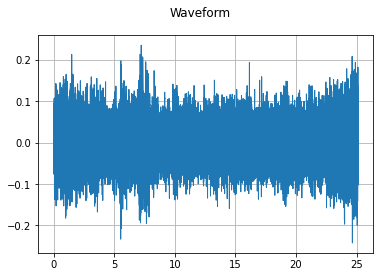

In [203]:
plot_waveform(waveform,sample_rate=sample_rate)

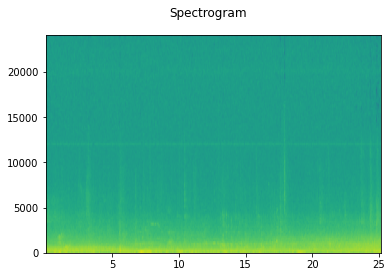

In [204]:
# spectrogram showcase repartition of frequencies in the sample
plot_specgram(waveform,sample_rate)

In [205]:
waveform.shape

torch.Size([1, 1205702])

### Spectrogram

Shape: (1, 257, 4020)
Dtype: torch.float32
 - Max:     2266.238
 - Min:      0.000
 - Mean:     0.463
 - Std Dev:  8.412

tensor([[[6.6957e+00, 2.1561e+00, 4.6595e+01,  ..., 3.1264e+02,
          1.2049e+02, 4.5968e+01],
         [1.8573e+01, 1.9900e+00, 2.1642e+01,  ..., 7.9470e+01,
          1.1748e+02, 4.1576e+01],
         [2.9168e+01, 2.3282e+00, 7.9817e+00,  ..., 5.9535e+00,
          4.9554e+01, 4.0341e+00],
         ...,
         [3.9789e-04, 6.7017e-05, 1.5324e-04,  ..., 4.8010e-04,
          4.3796e-04, 5.4900e-04],
         [1.4933e-05, 7.4006e-04, 2.6705e-04,  ..., 6.7338e-04,
          3.2992e-04, 2.8578e-05],
         [2.9619e-06, 2.0484e-03, 7.3718e-05,  ..., 1.8313e-04,
          2.7647e-05, 2.2610e-05]]])



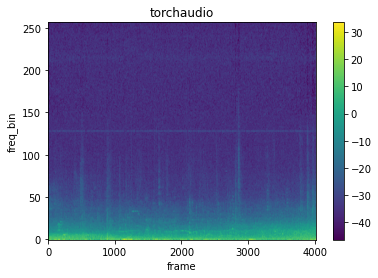

In [206]:
n_fft = 512
win_length = None
hop_length = 300

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')

### MFCC

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "


Shape: (1, 256, 2355)
Dtype: torch.float32
 - Max:     201.191
 - Min:     -174.160
 - Mean:    -2.460
 - Std Dev: 14.003

tensor([[[-148.5692, -132.4215, -124.1226,  ...,  -87.1527,  -82.2163,
           -80.6839],
         [ 139.2230,  142.4588,  144.5152,  ...,  174.6792,  182.2250,
           186.5164],
         [  28.0115,   21.3795,   15.0523,  ...,   16.8636,   21.2966,
            17.6706],
         ...,
         [   4.5170,    4.9755,    6.0181,  ...,    4.4051,    4.2305,
             7.4539],
         [   4.5972,    4.0824,    3.5255,  ...,    3.6001,    2.8497,
             2.9007],
         [   4.9368,    2.9696,    1.9949,  ...,    1.6660,    0.6151,
            -1.2160]]])



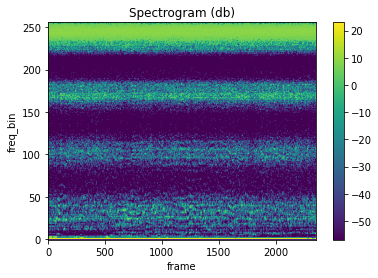

In [207]:

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)
print_stats(mfcc)
plot_spectrogram(mfcc[0])

In [208]:
from torchaudio.transforms import MFCC

In [209]:
def clean_mfcc(data):
  pass

def clean_spectrogram(data):
  pass

## Dataset

### Raw

In [216]:
class SoundDataset(Dataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList):
        #initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []
        self.folders = []
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i,1] in folderList:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i,1])
                #self.folders.append(csvData.iloc[i, 5])
                
        self.file_path = file_path
         #self.mixer = torchaudio.transforms.DownmixMono() 
        self.folderList = folderList
        
    def __getitem__(self, index):
        #format the file path and load the file
        path = self.file_path + self.file_names[index]
        sound = torchaudio.load(path, normalize = True)
        #load returns a tensor with the sound data and the sampling frequency (44.1kHz for UrbanSound8K)

        # soundData = torch.mean(sound[0], dim=0).unsqueeze(0) # #UrbanSound8K uses two channels, this will convert them to one
        soundData = sound[0]
        #downsample the audio to ~8kHz
        tempData = torch.zeros([160000, 1]) #tempData accounts for audio clips that are too short
        if soundData.numel() < 160000:
            tempData[:soundData.numel()] = soundData[:].T
        else:
            tempData[:] = soundData[:,:160000].T
        
        soundData = tempData
        soundFormatted = torch.zeros([32000, 1])
        soundFormatted[:32000] = soundData[::5] #take every fifth sample of soundData
        soundFormatted = soundFormatted.permute(1, 0)
        return soundFormatted, self.labels[index]
    
    def __len__(self):
        return len(self.file_names)


In [217]:
os.chdir("/content/")

In [218]:
csv_path = './building_floor_recognition.csv'
file_path = './Data/'


In [259]:
X_train, X_test = train_test_split(dataset, test_size=0.2, stratify = dataset.floor)

In [264]:
list(range(1,5))

[1, 2, 3, 4]

In [265]:
all_set = SoundDataset(dataset, file_path, range(0,6))

train_set = SoundDataset(X_train, file_path, range(0,6))
test_set = SoundDataset(X_test, file_path, range(0,6))
print("Alll set size: " + str(len(all_set)))
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 5, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 5, shuffle = True, **kwargs)

Alll set size: 26
Train set size: 20
Test set size: 6


In [266]:
os.getcwd()

'/content'

In [267]:
train_set[4]

(tensor([[-0.0082, -0.0076, -0.0025,  ...,  0.0286,  0.0280,  0.0241]]), 0)

### Spectrogram

In [268]:
class SpecSoundDataset(SoundDataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList, n_fft, win_length = None, center = True, pad_mode = "reflect", power = 2.0):
        super().__init__(csvData, file_path, folderList)
        self._n_fft = n_fft
        self._win_length = win_length
        self._hop_length = hop_length
        self._center = center
        self._pad_mode = pad_mode
        self._power = power
        # define transformation
        spectrogram = T.Spectrogram(
          n_fft= self._n_fft,
          win_length=self._win_length,
          hop_length=self._hop_length,
          center=self._center,
          pad_mode=self._pad_mode,
          power=self._power,
        )
        self._spec_mixer = spectrogram
    def __getitem__(self, index):
      soundFormatted, labels= super().__getitem__(index)
      # apply transformation
      return self._spec_mixer(soundFormatted), labels

    
    def __len__(self):
        return len(self.file_names)

In [269]:

# configure spectrogram settings 
config_spec_args = {
    'n_fft':512,
}

test_train_set = SpecSoundDataset(X_train, file_path, range(1,10), **config_spec_args)
test_test_set = SpecSoundDataset(X_test, file_path, [10], **config_spec_args)
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))


Train set size: 20
Test set size: 6


In [270]:
train_set[2][0].shape

torch.Size([1, 32000])

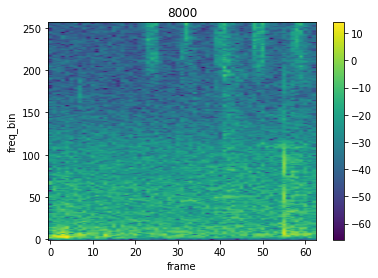

In [271]:
plot_spectrogram(test_train_set[2][0][0],8000)

### MFCC

In [272]:
class MFCCSoundDataset(SoundDataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csvData, file_path, folderList, n_mfcc, sample_rate, n_fft = None, n_mels = None, mel_scale = 'htk'):
        super().__init__(csvData, file_path, folderList)
        self._n_fft = n_fft
        self._win_length = win_length
        self._hop_length = hop_length
        self._n_mels = n_mels
        self._n_mfcc = n_mfcc 
        self._sample_rate = sample_rate
        self._mel_scale = mel_scale
        # define transformation
        
        mfcc_transform = T.MFCC(
            sample_rate= self._sample_rate,
            n_mfcc=self._n_mfcc,
            melkwargs={
              'n_fft': self._n_fft,
              'n_mels': self._n_mels,
              'hop_length': self._hop_length,
              'mel_scale': self._mel_scale,
            }
        )

        self._mfcc_transform = mfcc_transform
    def __getitem__(self, index):
      soundFormatted, labels= super().__getitem__(index)
      # apply transformation
      return self._mfcc_transform(soundFormatted), labels

    
    def __len__(self):
        return len(self.file_names)

In [227]:

# configure spectrogram settings 
config_spec_args = {
    'n_fft':512,
    'n_mfcc':180,
    'sample_rate':8000,
    'n_mels':180,

}

test_train_set = MFCCSoundDataset(X_train, file_path, range(1,10), **config_spec_args)
test_test_set = MFCCSoundDataset(X_test, file_path, [10], **config_spec_args)
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))


Train set size: 9
Test set size: 3


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (180) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


In [228]:
test_train_set[2][0].shape

torch.Size([1, 180, 63])

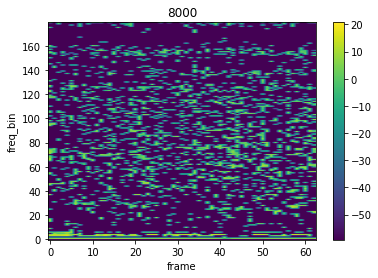

In [229]:
plot_spectrogram(test_train_set[2][0][0],8000)

In [230]:
# cleaning 
try:
    del test_train_set
    del test_test_set
except NameError:
    pass

## Models

In [231]:
class SimpleNet(nn.Module):
    def __init__(self,in_channels=1,n_output=3):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv1d(in_channels, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
        
            nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv1d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv1d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),

            nn.Conv1d(256,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),

            nn.Conv1d(128,32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32000,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,n_output)
        )
    
    def forward(self, xb):
        emb = self.network(xb)
        return self.classifier(emb)


In [232]:
# net=SimpleNet()

In [233]:
# train_set[0][0].unsqueeze(0).shape

In [234]:
# conv= nn.Conv1d(1, out_channels = 32, kernel_size = 3, padding = 1)

In [235]:
# net(train_set[0][0].unsqueeze(0))

In [236]:
class MFCCClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def __forward(self,X):
    pass

In [237]:
class Rawlassifier(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def __forward(self,X):
    pass

In [238]:
class SpectrogramClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def __forward(self,X):
    pass

In [239]:
class LateFusionClassifier(nn.Module):
  # Model used in late fusion classification
  def __init__(self,estimators,ensemble_model):
    super().__init__()
    self._estimators = [est.copy() for est in estimators]
    self._ensemble = ensemble_model
    pass
  def forward(self,X):
    for i,est in enumerate(self._estimators):
      self._estimators.eval()
      est.forward(X[i]) # concat les resultats
    self._ensemble.forward(X)
  

In [240]:
class EarlyFusionClassifier(nn.Module):
  def __init__(self,estimators,ensemble_model):
    super().__init__()
    self._estimators = [est.copy() for est in estimators]
    self._ensemble = ensemble_model
    pass
  def forward(self,X):
    for i,est in enumerate(self._estimators):
      self._estimators.eval()
      est.forward(X[i]) # concat les resultats
    self._ensemble.forward(X)
  

## Training

### utils

In [241]:
# Reporting strategies

class Reporter:
  # proxy used for any reporter ( wandb, tensorboard, etc)
  def __init__(self):
    pass

  def log(self,data:Dict[str, Any]):
    raise NotImplementedError

  def stop(self):
    raise NotImplementedError

class WandbReporter(Reporter):
  def __init__(self,wandb):
    self._wandb=wandb
    super().__init__()
  
  def log(self,data:Dict[str, Any]):
    self._wandb.log(kwargs)

  def stop(self):
    self._wandb.finish()

In [242]:
# Function to save the model
def saveModel(model,path = "./myFirstModel.pth"):
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def valid(model,test_loader,loss_fn,device):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return (loss, accuracy)



# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model,train_loader,optimizer,loss_fn,eval_loader=None,num_epochs = 10,train_steps=1000,eval_steps=1000,device=torch.device("cpu"),reporter=None):
    
    best_accuracy = 0.0
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % (train_steps) == (train_steps-1):    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / train_steps))
                if reporter:
                    reporter.log({'training loss':running_loss})
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        eval_loss, accuracy = valid(model,eval_loader,loss_fn,device)
        print('Epoch[', epoch+1,'] eval accuracy %d %%' % (accuracy),"eval loss %.3f %%" % (eval_loss))
        if reporter:
          reporter.log({'eval loss':eval_loss,'eval accuracy':accuracy})
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel(model)
            best_accuracy = accuracy
    if reporter:
      reporter.stop()

In [273]:
# define a cross validation function
def crossvalid(model=None,criterion=None,dataset=None,k_fold=5,device=torch.device("cpu")):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        print(f"Fold {i+1} training")
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        

        print("train indices: [%d,%d),[%d,%d), test indices: [%d,%d)" 
                % (trll,trlr,trrl,trrr,vall,valr))
 
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)


        _train_loader = train_loader #torch.utils.data.DataLoader(train_set, batch_size=5,shuffle=True)
        _val_loader = test_loader #torch.utils.data.DataLoader(val_set, batch_size=5,shuffle=True)
        
        res_model = deepcopy(model)
        _optimizer = torch.optim.Adam(res_model.parameters(), lr=3e-4)
        train_acc = train(res_model,_train_loader,_optimizer,criterion,eval_loader=_val_loader,num_epochs = 1, train_steps=1,device=device)
        train_score.at[i] = train_acc
        val_acc = valid(res_model,_val_loader,criterion,device)
        val_score.at[i] = val_acc
        del res_model
    
    return train_score,val_score
        



### Direct model training

In [274]:
net = SimpleNet(in_channels=1,n_output=2)
rate_learning = 3e-4

In [275]:
net

SimpleNet(
  (network): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): ReLU()
    (7): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): ReLU()
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): ReLU()
    (12): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): ReLU()
    (17): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (18): Conv1d(

In [276]:

model = net
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('Approximated model size: {:.3f}MB'.format(size_all_mb))

Approximated model size: 128.866MB


In [277]:
optimizer = torch.optim.Adam(net.parameters(), lr=rate_learning)
loss_fn = nn.CrossEntropyLoss()

In [278]:
os.chdir("/content/")

In [279]:
print("The model will be running on", device, "device")
train_score,val_score = crossvalid(net,loss_fn,dataset=all_set,device = device, k_fold=5)

The model will be running on cpu device
Fold 1 training
train indices: [0,0),[5,26), test indices: [0,5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


[1,     1] loss: 0.697
[1,     2] loss: 0.675
[1,     3] loss: 0.856
[1,     4] loss: 0.673
Epoch[ 1 ] eval accuracy 50 % eval loss 0.817 %
Fold 2 training
train indices: [0,5),[10,26), test indices: [5,10)
[1,     1] loss: 0.689
[1,     2] loss: 0.787


KeyboardInterrupt: ignored

In [ ]:
net.to(device)

In [ ]:
!set CUDA_LAUNCH_BLOCKING=1

In [ ]:
net = SimpleNet(in_channels=1,n_output=2)
rate_learning = 3e-4

In [ ]:
r_model = deepcopy(net)
optimizer = torch.optim.Adam(r_model.parameters(), lr=rate_learning)

In [ ]:
train(r_model,train_loader,optimizer,loss_fn,eval_loader=test_loader,num_epochs = 6,train_steps=1,device=device)